### Import Libraries

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

### Read the data

We load the dataset twice just to have the comfort to return to the original dataset in case of mistakes or changes in the preprocessing strategy.

In [175]:
Train_set = pd.read_csv('train.csv', index_col='PassengerId')
Test_set = pd.read_csv('test.csv', index_col='PassengerId')
del Test_set['Ticket']
del Train_set['Ticket']

In [176]:
Train_set.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,NaN,S


In [177]:
Test_set.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
PassengerId,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,12.2875,NaN,S


In [178]:
Train_Id = len(Train_set)
Data = pd.concat([Train_set.iloc[:,1:],Test_set])
Data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
PassengerId,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,NaN,S
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C85,C
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,NaN,S
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C123,S
5,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,NaN,S


In [179]:
Data.shape

(1309, 9)

Extract information about the title of each passenger

In [180]:
Title = []
for i in range(1,len(Data)+1):
    Title.append(Data.loc[i,'Name'].split(',')[1].split('.')[0].strip())
Data['Title'] = Title

Encode the Sex variable

In [181]:
Sex_map = {'male':0, 'female':1}
Data['Sex'].replace(Sex_map, inplace = True)

#### Add a Relatives column
Columns SibSp and Parch are both referring to the relatives that each passenger had on Titanic. So, we create an extra feature named Relatives which simply adds the two columns.

In [182]:
Data['Relatives'] = (Data['SibSp']+Data['Parch']+1)
Data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,Relatives
PassengerId,,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500,NaN,S,Mr,2
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,71.2833,C85,C,Mrs,2
3,3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250,NaN,S,Miss,1
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,53.1000,C123,S,Mrs,2
5,3,"Allen, Mr. William Henry",0,35.0,0,0,8.0500,NaN,S,Mr,1


# Missing Values

In [183]:
Data.isna().sum()

Pclass          0
Name            0
Sex             0
Age           263
SibSp           0
Parch           0
Fare            1
Cabin        1014
Embarked        2
Title           0
Relatives       0
dtype: int64

We have at first to fill the Fare missing value. This is important because we will use the Fare later to fill the missing values of the cabin variable.

First we search for the missing value.

In [184]:
Data[Data['Fare'].isna() == True]

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,Relatives
PassengerId,,,,,,,,,,,
1044,3,"Storey, Mr. Thomas",0,60.5,0,0,NaN,NaN,S,Mr,1


It 's a 60 years old individual whose his fare we do not know. We can estimate it though in a clever way using the fact that he is a 3rd class Mister and Embarked from Southampton with no other Relatives.

In [185]:
Fillna_Fare_dataset = Data[(Data['Pclass'] == 3) & (Data['Embarked'] == 'S') & 
                    (Data['Title'] == 'Mr') & (Data['Relatives'] == 1)]
Fillna_Fare_dataset.shape

(278, 11)

We get 278 passengers with the same characteristics as the Mister whose fare we do not know. We fill the missing value with the median of the Fare column.

In [186]:
Fillna_Fare_dataset.Fare.median()

7.8958

In [187]:
Data.Fare.fillna(value = Fillna_Fare_dataset.Fare.median(), inplace=True)
Data.Fare.isna().sum()

0

We add a 'Fair per person' variable, which correlates the fare with the number of relatives. This may prove valuable, because a cabin might be shared from two or more passengers.

In [188]:
Data['Fare per person'] = Data['Fare'] / Data['Relatives']
Data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,Relatives,Fare per person
PassengerId,,,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500,NaN,S,Mr,2,3.62500
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,71.2833,C85,C,Mrs,2,35.64165
3,3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250,NaN,S,Miss,1,7.92500
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,53.1000,C123,S,Mrs,2,26.55000
5,3,"Allen, Mr. William Henry",0,35.0,0,0,8.0500,NaN,S,Mr,1,8.05000


### Dealing with the missing values of Cabin variable

The Cabin variable is the most difficult one to handle in the titanic dataset. It has about 77% missing values and yet it is important so we can't just ignore it. That is because at the colision time (about 11:40 am) most of the passengers were on their cabins and also the cabins at the lower decks flooded significantly faster than the higher ones.

In [189]:
per = Data.Cabin.isna().sum() / len(Data.Cabin)
print("Missing values percentage : {0:.2%}".format(per))

Missing values percentage : 77.46%


The strategy we follow takes into account the fare, the number of relatives and the class of the passengers. A decision tree algorithm will try and learn from not missing values the correlations between the above features and the cabin letter, which states for the cabin's Deck. We employ a decision tree algorithm for each class. The problem with this tactic is that we do not have enough observations for classes 2 and 3 but for now we will continue like this is not something to worry about.

In [190]:
Cabin = Data['Cabin']
Cabin = Cabin[Cabin.notnull()]
Cabin.head()

PassengerId
2      C85
4     C123
7      E46
11      G6
12    C103
Name: Cabin, dtype: object

In [191]:
Cabin_deck = []
for i in range(len(Cabin)):
    Cabin_deck.append(Cabin.iloc[i][0])

In [192]:
Known_cabin_passengers = Data[['Pclass','Sex','Fare per person','Fare','Cabin']]
Known_cabin_passengers = Known_cabin_passengers[Known_cabin_passengers.Cabin.notnull()]
Known_cabin_passengers.reset_index(inplace = True, drop = False)
Known_cabin_passengers.head()

,PassengerId,Pclass,Sex,Fare per person,Fare,Cabin
0,2,1,1,35.641650,71.2833,C85
1,4,1,1,26.550000,53.1000,C123
2,7,1,0,51.862500,51.8625,E46
3,11,3,1,5.566667,16.7000,G6
4,12,1,1,26.550000,26.5500,C103


In [193]:
Known_cabin_passengers.shape

(295, 6)

In [194]:
Deck = []
for i in range(len(Known_cabin_passengers)):
    Deck.append(Known_cabin_passengers.loc[i,'Cabin'][0])
Known_cabin_passengers['Deck'] = Deck
del Known_cabin_passengers['Cabin']
Known_cabin_passengers.head()

,PassengerId,Pclass,Sex,Fare per person,Fare,Deck
0,2,1,1,35.641650,71.2833,C
1,4,1,1,26.550000,53.1000,C
2,7,1,0,51.862500,51.8625,E
3,11,3,1,5.566667,16.7000,G
4,12,1,1,26.550000,26.5500,C


In [195]:
Cabin_handle = Known_cabin_passengers.groupby(['Pclass', 'Deck'])
Cabin_handle['Fare per person'].mean()

Pclass  Deck
1       A       31.608805
        B       68.796005
        C       59.303370
        D       35.518734
        E       37.722550
        T       35.500000
2       D       13.595833
        E       11.587500
        F       10.423077
3       E        6.841667
        F        7.532646
        G        5.083750
Name: Fare per person, dtype: float64

##### Class 1
Both 'Fare' and 'Fare per person' indicate that there is a significant difference between the Cabin price of B and C Decks. So B and C cabins will be grouped together. Since the decks are one on top of the other, it is wise to encode the categorical variables in a descending form. For example, Deck A and T are the top decks, so they will be encoded with 0. Decks B and C are below A respectively, but they are both encoded together with 1.

Despite the fact that the above table provided us with some valuable insights, it also provided us with some problems. We notice for example that the price for A and T cabins are very close to those of D and E and as a result, our classifier may encounter problems trying to decide between decks that are not B or C. Luckily, we notice that the majority of the people that occupied the A cabins were males. That is not the case for the rest of the Decks, so we found a variable that will help the algorithm to make more accurate classification. It seems that Sex solve our problems! 

In [196]:
Grouped_sex_1 = Known_cabin_passengers.groupby(['Pclass','Deck','Sex'])
Grouped_sex_1.Fare.count()

Pclass  Deck  Sex
1       A     0      18
              1       4
        B     0      29
              1      36
        C     0      48
              1      46
        D     0      19
              1      21
        E     0      20
              1      14
        T     0       1
2       D     0       4
              1       2
        E     1       4
        F     0       6
              1       7
3       E     0       2
              1       1
        F     0       7
              1       1
        G     1       5
Name: Fare, dtype: int64

In [197]:
Known_cabin_passengers[Known_cabin_passengers['Deck'] == 'A'].Sex.value_counts()

0    18
1     4
Name: Sex, dtype: int64

Deck A seems to have relatively high male/female rate comparing to the other first class decks. That is why for class 1 we incorporate Sex feature.

In [198]:
Grouped = Known_cabin_passengers.groupby(['Pclass','Deck'])
Grouped.Fare.count()

Pclass  Deck
1       A       22
        B       65
        C       94
        D       40
        E       34
        T        1
2       D        6
        E        4
        F       13
3       E        3
        F        8
        G        5
Name: Fare, dtype: int64

In [199]:
Missing = Data[Data['Cabin'].isna() == True].groupby(['Pclass'])
Missing.Fare.count()

Pclass
1     67
2    254
3    693
Name: Fare, dtype: int64

##### Class 2 & 3
And this is the problem with class 2 and 3. For Class 2, we need to decide on the cabin of 254 passengers, using only the data of 23! It is even worse for Class 3, having data from only 16 passengers and we need to decide for nearly 700! However, the DecisionTreeClassifier does not suffer from overfitting issues, especially since we use only two columns to decide. In addition, we only need to fill the column with passengers cabin 's Deck and maybe it 's not that decisive to classify someone as Deck F while he had actually a Cabin in Deck G. 
In other words, the amount of noise we introduce to our data with this technique worths the amount of information we gain by not ignoring the entire column.

In [200]:
x_1_test = Data[(Data['Pclass'] == 1) & (Data['Cabin'].isna() == True)]
x_1_test = x_1_test[['Fare','Fare per person','Sex']]

x_2_test = Data[(Data['Pclass'] == 2) & (Data['Cabin'].isna() == True)]
x_2_test = x_2_test[['Fare','Fare per person']]

x_3_test = Data[(Data['Pclass'] == 3) & (Data['Cabin'].isna() == True)]
x_3_test = x_3_test[['Fare','Fare per person']]

In [201]:
Class_1 = Known_cabin_passengers[Known_cabin_passengers['Pclass'] == 1]
deck_map = {'A':0, 'B':1, 'C':1, 'D':2, 'E':2, 'T':0}
Class_1['Deck'].replace(deck_map, inplace = True)
Class_1 = Class_1[['Fare','Fare per person','Sex','Deck']]
Class_1_x = Class_1[['Fare','Fare per person','Sex']]
Class_1_y = Class_1['Deck']
scaler = StandardScaler()
scaled_x_1 = scaler.fit_transform(Class_1_x)
scaled_x_1_test = scaler.transform(x_1_test)

dct_param_grid = {'dct__criterion': ['gini','entropy'],
                  'dct__splitter': ['best','random']}

pipe_dct = Pipeline([('scaler', StandardScaler()),
                    ('dct',DecisionTreeClassifier())])

gs_dct = GridSearchCV(pipe_dct, dct_param_grid, cv=3, scoring = "accuracy", refit = True)
gs_dct.fit(scaled_x_1, Class_1_y)
predictions_1 = gs_dct.predict(scaled_x_1_test)

pred_1 = gs_dct.best_estimator_.predict(scaled_x_1)
print("Accuracy: {0:.2f} %".format(round(100*accuracy_score(Class_1_y, pred_1),2)))
print('')
# Best estimator hyperparameters

print(gs_dct.best_params_)

Accuracy: 91.80 %

{'dct__criterion': 'gini', 'dct__splitter': 'best'}


C:\Users\user\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:6586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [202]:
Class_2 = Known_cabin_passengers[Known_cabin_passengers['Pclass'] == 2]
deck_map = {'D':2, 'E':2, 'F':3}
Class_2['Deck'].replace(deck_map, inplace = True)
Class_2 = Class_2[['Fare','Fare per person','Deck']]
Class_2_x = Class_2[['Fare','Fare per person']]
Class_2_y = Class_2['Deck']
scaler = StandardScaler()
scaled_x_2 = scaler.fit_transform(Class_2_x)
scaled_x_2_test = scaler.transform(x_2_test)

dct_param_grid = {'dct__criterion': ['gini','entropy'],
                  'dct__splitter': ['best','random']}

pipe_dct = Pipeline([('scaler', StandardScaler()),
                    ('dct',DecisionTreeClassifier())])

gs_dct = GridSearchCV(pipe_dct, dct_param_grid, cv=3, scoring = "accuracy", refit = True)
gs_dct.fit(scaled_x_2, Class_2_y)
predictions_2 = gs_dct.predict(scaled_x_2_test)

pred_2 = gs_dct.best_estimator_.predict(scaled_x_2)
print("Accuracy: {0:.2f} %".format(round(100*accuracy_score(Class_2_y, pred_2),2)))
print('')
# Best estimator hyperparameters

print(gs_dct.best_params_)

Accuracy: 78.26 %

{'dct__criterion': 'gini', 'dct__splitter': 'best'}


C:\Users\user\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:6586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [203]:
Class_3 = Known_cabin_passengers[Known_cabin_passengers['Pclass'] == 3]
deck_map = {'E':2, 'F':3, 'G':4}
Class_3['Deck'].replace(deck_map, inplace = True)
Class_3 = Class_3[['Fare','Fare per person','Deck']]
Class_3_x = Class_3[['Fare','Fare per person']]
Class_3_y = Class_3['Deck']
scaler = StandardScaler()
scaled_x_3 = scaler.fit_transform(Class_3_x)
scaled_x_3_test = scaler.transform(x_3_test)

dct_param_grid = {'dct__criterion': ['gini','entropy'],
                  'dct__splitter': ['best','random']}

pipe_dct = Pipeline([('scaler', StandardScaler()),
                    ('dct',DecisionTreeClassifier())])

gs_dct = GridSearchCV(pipe_dct, dct_param_grid, cv=3, scoring = "accuracy", refit = True)
gs_dct.fit(scaled_x_3, Class_3_y)
predictions_3 = gs_dct.predict(scaled_x_3_test)

pred_3 = gs_dct.best_estimator_.predict(scaled_x_3)
print("Accuracy: {0:.2f} %".format(round(100*accuracy_score(Class_3_y, pred_3),2)))
print('')
# Best estimator hyperparameters

print(gs_dct.best_params_)

Accuracy: 100.00 %

{'dct__criterion': 'gini', 'dct__splitter': 'best'}


C:\Users\user\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:6586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [204]:
unique, counts = np.unique(predictions_1, return_counts=True)
print("Predictions for 1st Class: " + str(dict(zip(unique, counts))))
unique, counts = np.unique(predictions_2, return_counts=True)
print("Predictions for 2nd Class: " + str(dict(zip(unique, counts))))
unique, counts = np.unique(predictions_3, return_counts=True)
print("Predictions for 3rd Class: " + str(dict(zip(unique, counts))))

Predictions for 1st Class: {0: 14, 1: 34, 2: 19}
Predictions for 2nd Class: {2: 175, 3: 79}
Predictions for 3rd Class: {2: 194, 3: 363, 4: 136}


In [205]:
Data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,Relatives,Fare per person
PassengerId,,,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500,NaN,S,Mr,2,3.62500
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,71.2833,C85,C,Mrs,2,35.64165
3,3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250,NaN,S,Miss,1,7.92500
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,53.1000,C123,S,Mrs,2,26.55000
5,3,"Allen, Mr. William Henry",0,35.0,0,0,8.0500,NaN,S,Mr,1,8.05000


In [206]:
Data['Deck'] = np.zeros(len(Data))
count_1=0
count_2=0
count_3=0
for i in range(1,len(Data)+1):
    if (Data.loc[i,'Pclass'] == 1) & (type(Data.loc[i,'Cabin']) != str):
        Data.loc[i,'Deck'] = predictions_1[count_1]
        count_1 += 1
    elif (Data.loc[i,'Pclass'] == 2) & (type(Data.loc[i,'Cabin']) != str):
        Data.loc[i,'Deck'] = predictions_2[count_2]
        count_2 += 1
    elif (Data.loc[i,'Pclass'] == 3) & (type(Data.loc[i,'Cabin']) != str):
        Data.loc[i,'Deck'] = predictions_3[count_3]
        count_3 += 1
Data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,Relatives,Fare per person,Deck
PassengerId,,,,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500,NaN,S,Mr,2,3.62500,4.0
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,71.2833,C85,C,Mrs,2,35.64165,0.0
3,3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250,NaN,S,Miss,1,7.92500,2.0
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,53.1000,C123,S,Mrs,2,26.55000,0.0
5,3,"Allen, Mr. William Henry",0,35.0,0,0,8.0500,NaN,S,Mr,1,8.05000,2.0


In [207]:
for i in range(1,len(Data)+1):
    if type(Data.loc[i,'Cabin']) == str:
        Data.loc[i,'Deck'] = Data.loc[i,'Cabin'][0]
Data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,Relatives,Fare per person,Deck
PassengerId,,,,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500,NaN,S,Mr,2,3.62500,4
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,71.2833,C85,C,Mrs,2,35.64165,C
3,3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250,NaN,S,Miss,1,7.92500,2
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,53.1000,C123,S,Mrs,2,26.55000,C
5,3,"Allen, Mr. William Henry",0,35.0,0,0,8.0500,NaN,S,Mr,1,8.05000,2


In [208]:
Cabin_map = {'A':0, 'B':1, 'C':1, 'D':2, 'E':2, 'F':3, 'G':4, 'T':0}
Data['Deck'].replace(Cabin_map, inplace = True)
Data['Deck'] = Data['Deck'].astype(int)
Data.drop(columns = 'Cabin', inplace = True)
Data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 12 columns):
Pclass             1309 non-null int64
Name               1309 non-null object
Sex                1309 non-null int64
Age                1046 non-null float64
SibSp              1309 non-null int64
Parch              1309 non-null int64
Fare               1309 non-null float64
Embarked           1307 non-null object
Title              1309 non-null object
Relatives          1309 non-null int64
Fare per person    1309 non-null float64
Deck               1309 non-null int32
dtypes: float64(3), int32(1), int64(5), object(3)
memory usage: 167.8+ KB


In [209]:
Data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Relatives,Fare per person,Deck
PassengerId,,,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500,S,Mr,2,3.62500,4
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,71.2833,C,Mrs,2,35.64165,1
3,3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250,S,Miss,1,7.92500,2
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,53.1000,S,Mrs,2,26.55000,1
5,3,"Allen, Mr. William Henry",0,35.0,0,0,8.0500,S,Mr,1,8.05000,2


In [210]:
Data.Deck.value_counts()

2    475
3    463
1    193
4    141
0     37
Name: Deck, dtype: int64

### Dealing with the Age missing values

A common strategy to handle the missing values of a quantitative variable is to fill them with the mean or the median. However, this will add to much noise in that feature, as not only there is a large number of missing values, but also there is a wide range of ages and filling almost the 20% of the whole column with the same number will make no good for our dataset. 

In [211]:
per = Data.Age.isna().sum() / len(Data.Age)
print("Missing values percentage : {0:.2%}".format(per))

Missing values percentage : 20.09%


We use the same clever approach to fill the missing values for the Age as we did for Fare. This time we assume that a passenger 's Age is correlated with the Title, Class and Sex. This is where the Title variable come into play, as we notice that there are some differences about a passenger 's age regarding the title. For example, the title "Master" is highly used for male children. So we fill the missing values of the Age variable with the median of the respective Title, Class and Sex.

In [212]:
Age_handle = Data.groupby(['Sex','Pclass','Title'])
Age_handle.Age.median()

Sex  Pclass  Title       
0    1       Capt            70.0
             Col             54.5
             Don             40.0
             Dr              47.0
             Jonkheer        38.0
             Major           48.5
             Master           6.0
             Mr              41.5
             Sir             49.0
     2       Dr              38.5
             Master           2.0
             Mr              30.0
             Rev             41.5
     3       Master           6.0
             Mr              26.0
1    1       Dona            39.0
             Dr              49.0
             Lady            48.0
             Miss            30.0
             Mlle            24.0
             Mme             24.0
             Mrs             45.0
             the Countess    33.0
     2       Miss            20.0
             Mrs             30.5
             Ms              28.0
     3       Miss            18.0
             Mrs             31.0
             Ms       

We notice that 3rd Class Ms category has only missing values. We replace the 'Ms' Title with the 'Miss' Title to tackle this problem.

In [269]:
Ms_map = {'Ms':'Miss'}
Data['Title'].replace(Ms_map, inplace = True)
Age_handle = Data.groupby(['Sex','Pclass','Title'])

In [270]:
Data.Age = Age_handle.Age.apply(lambda x: x.fillna(x.median()))

In [271]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 13 columns):
Pclass             1309 non-null int64
Name               1309 non-null object
Sex                1309 non-null int64
Age                1309 non-null float64
SibSp              1309 non-null int64
Parch              1309 non-null int64
Fare               1309 non-null float64
Embarked           1309 non-null object
Title              1309 non-null object
Relatives          1309 non-null int64
Fare per person    1309 non-null float64
Deck               1309 non-null int32
Baby on board      1309 non-null float64
dtypes: float64(4), int32(1), int64(5), object(3)
memory usage: 178.1+ KB


### Dealing with the Embarked missing values

This feature is much easier to handle, as it has only two missing values. A common technique to tackle this problem is to assign the most frequent value of the column 'Embarked', that is 'S' for Southampton. However, Titanic is the most famous maritime disaster and some passengers are very easy to be googled. From the Name feature we google the two names and we find out that they were a couple that embarked from Southampton.

In [216]:
Data[Data.Embarked.isna()]

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Relatives,Fare per person,Deck
PassengerId,,,,,,,,,,,,
62,1,"Icard, Miss. Amelie",1,38.0,0,0,80.0,NaN,Miss,1,80.0,1
830,1,"Stone, Mrs. George Nelson (Martha Evelyn)",1,62.0,0,0,80.0,NaN,Mrs,1,80.0,1


In [217]:
Data.Embarked.fillna('S', inplace = True)

In [218]:
Data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Relatives,Fare per person,Deck
PassengerId,,,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500,S,Mr,2,3.62500,4
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,71.2833,C,Mrs,2,35.64165,1
3,3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250,S,Miss,1,7.92500,2
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,53.1000,S,Mrs,2,26.55000,1
5,3,"Allen, Mr. William Henry",0,35.0,0,0,8.0500,S,Mr,1,8.05000,2


### One hot Encoding

One hot Encoding is necessary for the Embarked and Title variables, as they are both categorical variables.

In [274]:
Data_Encoded = pd.get_dummies(Data, columns = ['Embarked',
                                               'Pclass'])
Data_Encoded.head()

,Name,Sex,Age,SibSp,Parch,Fare,Title,Relatives,Fare per person,Deck,Baby on board,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
PassengerId,,,,,,,,,,,,,,,,,
1,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500,Mr,2,3.62500,4,0.0,0,0,1,0,0,1
2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,71.2833,Mrs,2,35.64165,1,0.0,1,0,0,1,0,0
3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250,Miss,1,7.92500,2,0.0,0,0,1,0,0,1
4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,53.1000,Mrs,2,26.55000,1,0.0,0,0,1,1,0,0
5,"Allen, Mr. William Henry",0,35.0,0,0,8.0500,Mr,1,8.05000,2,0.0,0,0,1,0,0,1


In [275]:
Data_Encoded.Title.value_counts()

Mr              757
Miss            262
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Lady              1
Sir               1
Capt              1
Dona              1
the Countess      1
Mme               1
Don               1
Jonkheer          1
Name: Title, dtype: int64

In [276]:
Title_map = {'Don':'Royalty', 'Sir':'Royalty', 'Jonkheer':'Royalty', 'the Countess':'Royalty', 'Lady':'Royalty',
            'Dona':'Royalty','Dr':'Officer', 'Rev':'Officer', 'Col':'Officer', 'Major':'Officer','Capt':'Officer',
             'Mlle':'Miss', 'Mme':'Mrs'}
Data_Encoded['Title'].replace(Title_map, inplace = True)
Data_Encoded.Title.value_counts()

Mr         757
Miss       264
Mrs        198
Master      61
Officer     23
Royalty      6
Name: Title, dtype: int64

In [277]:
Data_Encoded_2 = pd.get_dummies(Data_Encoded, columns = ['Title'])
Data_Encoded_2.head()

,Name,Sex,Age,SibSp,Parch,Fare,Relatives,Fare per person,Deck,Baby on board,...,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500,2,3.62500,4,0.0,...,1,0,0,1,0,0,1,0,0,0
2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,71.2833,2,35.64165,1,0.0,...,0,1,0,0,0,0,0,1,0,0
3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250,1,7.92500,2,0.0,...,1,0,0,1,0,1,0,0,0,0
4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,53.1000,2,26.55000,1,0.0,...,1,1,0,0,0,0,0,1,0,0
5,"Allen, Mr. William Henry",0,35.0,0,0,8.0500,1,8.05000,2,0.0,...,1,0,0,1,0,0,1,0,0,0


In [278]:
Data_Encoded_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 22 columns):
Name               1309 non-null object
Sex                1309 non-null int64
Age                1309 non-null float64
SibSp              1309 non-null int64
Parch              1309 non-null int64
Fare               1309 non-null float64
Relatives          1309 non-null int64
Fare per person    1309 non-null float64
Deck               1309 non-null int32
Baby on board      1309 non-null float64
Embarked_C         1309 non-null uint8
Embarked_Q         1309 non-null uint8
Embarked_S         1309 non-null uint8
Pclass_1           1309 non-null uint8
Pclass_2           1309 non-null uint8
Pclass_3           1309 non-null uint8
Title_Master       1309 non-null uint8
Title_Miss         1309 non-null uint8
Title_Mr           1309 non-null uint8
Title_Mrs          1309 non-null uint8
Title_Officer      1309 non-null uint8
Title_Royalty      1309 non-null uint8
dtypes: float64(4), int32(

In [224]:
len(Data_Encoded_2.columns)

21

### Further feature Engineering

#### Classifying the Ages

Age is a crucial variable in the Titanic problem. There are groups of people that survived because they were young. In the following paragraph we 'll attempt to group the passengers into Age groups and add that features too. 

Survived
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Age, dtype: object

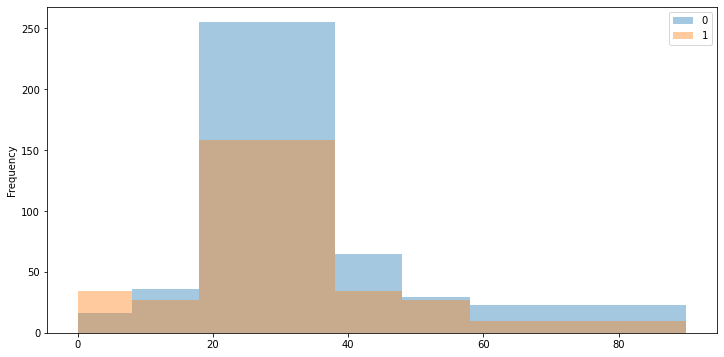

In [279]:
bin_values = [0,8,18,38,48,58,90]
group_carriers = Train_set.groupby('Survived')['Age'] # group values by carrier, select minutes delayed
group_carriers.plot(kind='hist', bins=bin_values, figsize=[12,6], alpha=.4, legend=True) # alpha for transparency

In [280]:
bin_values = [0,5,18,38,58,90]
Age_labels = ['Babies', 'Teens_and_Children', 'Young_Adults', 'Middle_Adults', 'Elder_people']
Ages = pd.cut(Train_set.Age,bin_values, labels = Age_labels)
Ages_dummies = pd.DataFrame(index = Train_set.index)
Ages_dummies['Survived'] = Train_set.Survived
Ages_dummies = pd.concat([pd.get_dummies(Ages, columns=Age_labels, sparse = True),Ages_dummies], axis=1)
Ages_dummies.head()

,Babies,Teens_and_Children,Young_Adults,Middle_Adults,Elder_people,Survived
PassengerId,,,,,,
1,0,0,1,0,0,0
2,0,0,1,0,0,1
3,0,0,1,0,0,1
4,0,0,1,0,0,1
5,0,0,1,0,0,0


In [281]:
Survival_Ratio = np.zeros(Ages_dummies.shape[1]-1)
for j in range(len(Survival_Ratio)):
    count = 0
    for i in range(len(Ages_dummies)):
        if (Ages_dummies.iloc[i,j] == 1) & (Ages_dummies.iloc[i,-1] == 1):
            count += 1
    Survival_Ratio[j] = count / Ages_dummies.iloc[:,j].value_counts()[1]

In [300]:
for i in range(len(Survival_Ratio)):
    print("{0} survival ratio: {1:.3f} %".format(Age_labels[i],round(100*Survival_Ratio[i],3)))

Babies survival ratio: 70.455 %
Teens_and_Children survival ratio: 41.053 %
Young_Adults survival ratio: 38.693 %
Middle_Adults survival ratio: 39.597 %
Elder_people survival ratio: 25.000 %


In [ ]:
print("Accuracy: {0:.2f} %".format(round(100*accuracy_score(Class_3_y, pred_3),2)))

In [283]:
Ages.value_counts()

Young_Adults          398
Middle_Adults         149
Teens_and_Children     95
Babies                 44
Elder_people           28
Name: Age, dtype: int64

Apply the Age classification to the whole Dataset

In [284]:
Ages = pd.cut(Data_Encoded_2.Age,bin_values, labels = Age_labels)
Ages_dummies = pd.DataFrame(index = Data_Encoded_2.index)
Ages_dummies = pd.concat([pd.get_dummies(Ages, columns=Age_labels, sparse = True),Ages_dummies], axis=1)
Data_Encoded_3 = pd.concat([Data_Encoded_2,Ages_dummies], axis=1)
Data_Encoded_3.head()

,Name,Sex,Age,SibSp,Parch,Fare,Relatives,Fare per person,Deck,Baby on board,...,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Babies,Teens_and_Children,Young_Adults,Middle_Adults,Elder_people
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500,2,3.62500,4,0.0,...,0,1,0,0,0,0,0,1,0,0
2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,71.2833,2,35.64165,1,0.0,...,0,0,1,0,0,0,0,1,0,0
3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250,1,7.92500,2,0.0,...,1,0,0,0,0,0,0,1,0,0
4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,53.1000,2,26.55000,1,0.0,...,0,0,1,0,0,0,0,1,0,0
5,"Allen, Mr. William Henry",0,35.0,0,0,8.0500,1,8.05000,2,0.0,...,0,1,0,0,0,0,0,1,0,0


#### What happens when a mother embarks with her baby?

During the passengers Age classification, we noticed the survival rates of the groups and a remarkable 70% arised for the Age group "Babies". That can easily be explained, because babies, children and women where the first to be put in the life-boats. And it is common sense that a baby most probably did not left the ship without his/her mother. It 's easy to assume that each mother or even father who had a baby in the ship also entered the life boat and as a result survived. So we first search for the babies by their name.  

In [286]:
Babies = Data[Data['Age'] <=5]
Babies.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Relatives,Fare per person,Deck,Baby on board
PassengerId,,,,,,,,,,,,,
8,3,"Palsson, Master. Gosta Leonard",0,2.0,3,1,21.0750,S,Master,5,4.215000,4,0.0
11,3,"Sandstrom, Miss. Marguerite Rut",1,4.0,1,1,16.7000,S,Miss,3,5.566667,4,0.0
17,3,"Rice, Master. Eugene",0,2.0,4,1,29.1250,Q,Master,6,4.854167,4,0.0
44,2,"Laroche, Miss. Simonne Marie Anne Andree",1,3.0,1,2,41.5792,C,Miss,4,10.394800,2,0.0
59,2,"West, Miss. Constance Mirium",1,5.0,1,2,27.7500,S,Miss,4,6.937500,3,0.0


In [287]:
len(Babies)

56

We tracked all the under 5 years old passengers and now we need to print their Surnames in order to find their Relatives.

In [288]:
Surname = []
for i in range(len(Babies)):
    Surname.append(Babies.iloc[i]['Name'].split(',')[0].strip())

In [289]:
# Initialize the "Baby on board" feature
Data['Baby on board'] = np.zeros(len(Data))

We assume that from the Relatives of each under age 5 child, we will find their siblings and their parents. We assume that their parents are at least 20 years old, so...

In [290]:
for k in range(len(Babies)):
    for i in range(len(Data)):
        if Surname[k] == Data['Name'].iloc[i].split(',')[0].strip():
            if Data['Age'].iloc[i] >= 20:
                Data['Baby on board'].iloc[i]=1

C:\Users\user\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [291]:
Data['Baby on board'].value_counts()

0.0    1254
1.0      55
Name: Baby on board, dtype: int64

In [292]:
Data_Encoded_3['Baby on board'] = Data['Baby on board']
del Data_Encoded_3['Name']
Data_Encoded_3.head()

,Sex,Age,SibSp,Parch,Fare,Relatives,Fare per person,Deck,Baby on board,Embarked_C,...,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Babies,Teens_and_Children,Young_Adults,Middle_Adults,Elder_people
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,22.0,1,0,7.2500,2,3.62500,4,0.0,0,...,0,1,0,0,0,0,0,1,0,0
2,1,38.0,1,0,71.2833,2,35.64165,1,0.0,1,...,0,0,1,0,0,0,0,1,0,0
3,1,26.0,0,0,7.9250,1,7.92500,2,0.0,0,...,1,0,0,0,0,0,0,1,0,0
4,1,35.0,1,0,53.1000,2,26.55000,1,0.0,0,...,0,0,1,0,0,0,0,1,0,0
5,0,35.0,0,0,8.0500,1,8.05000,2,0.0,0,...,0,1,0,0,0,0,0,1,0,0


In [293]:
Data_Encoded_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 26 columns):
Sex                   -1309 non-null int64
Age                   -1309 non-null float64
SibSp                 -1309 non-null int64
Parch                 -1309 non-null int64
Fare                  -1309 non-null float64
Relatives             -1309 non-null int64
Fare per person       -1309 non-null float64
Deck                  -1309 non-null int32
Baby on board         -1309 non-null float64
Embarked_C            -1309 non-null uint8
Embarked_Q            -1309 non-null uint8
Embarked_S            -1309 non-null uint8
Pclass_1              -1309 non-null uint8
Pclass_2              -1309 non-null uint8
Pclass_3              -1309 non-null uint8
Title_Master          -1309 non-null uint8
Title_Miss            -1309 non-null uint8
Title_Mr              -1309 non-null uint8
Title_Mrs             -1309 non-null uint8
Title_Officer         -1309 non-null uint8
Title_Royalty         -13

### Appendix: Survival Ratio of the Cabin Deck

The Deck variable as we mentioned before is the most difficult to handle due to the many missing values. However, a first indicator that the desicion tree classifier did a good job is to check the survival ratio for each deck and see if there is a significant difference in each deck between those who survived and those who did not.

In [304]:
Deck_dummies = pd.get_dummies(Data_Encoded_3.loc[:Train_Id, 'Deck'],prefix='Deck')
Deck_dummies['Survived'] = Train_set['Survived']
Deck_dummies.head()

,Deck_0,Deck_1,Deck_2,Deck_3,Deck_4,Survived
PassengerId,,,,,,
1,0,0,0,0,1,0
2,0,1,0,0,0,1
3,0,0,1,0,0,1
4,0,1,0,0,0,1
5,0,0,1,0,0,0


In [308]:
Survival_Ratio_Deck = np.zeros(Deck_dummies.shape[1]-1)
for j in range(len(Survival_Ratio_Deck)):
    count = 0
    for i in range(len(Deck_dummies)):
        if (Deck_dummies.iloc[i,j] == 1) & (Deck_dummies.iloc[i,-1] == 1):
            count += 1
    Survival_Ratio_Deck[j] = count / Deck_dummies.iloc[:,j].value_counts()[1]

In [310]:
for i in range(len(Survival_Ratio_Deck)):
    print("{0} survival ratio: {1:.3f} %".format(Deck_dummies.columns[i],round(100*Survival_Ratio_Deck[i],3)))

Deck_0 survival ratio: 38.095 %
Deck_1 survival ratio: 64.567 %
Deck_2 survival ratio: 38.855 %
Deck_3 survival ratio: 29.808 %
Deck_4 survival ratio: 30.303 %


We notice that as high the Deck, so high the survival ratio. This is an indicator that the Deck variable should do a good job at classifying the survived ones. The problem is the survival ratio of Deck 0. That 's why we 'll keep 5 features, one for each Deck and then possibly remove the Deck_0 variable after the feature importance check.

In [317]:
Data_Encoded_4 = pd.get_dummies(Data_Encoded_3,columns = ['Deck'])
Data_Encoded_4.head()

,Sex,Age,SibSp,Parch,Fare,Relatives,Fare per person,Baby on board,Embarked_C,Embarked_Q,...,Babies,Teens_and_Children,Young_Adults,Middle_Adults,Elder_people,Deck_0,Deck_1,Deck_2,Deck_3,Deck_4
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,22.0,1,0,7.2500,2,3.62500,0.0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,1,38.0,1,0,71.2833,2,35.64165,0.0,1,0,...,0,0,1,0,0,0,1,0,0,0
3,1,26.0,0,0,7.9250,1,7.92500,0.0,0,0,...,0,0,1,0,0,0,0,1,0,0
4,1,35.0,1,0,53.1000,2,26.55000,0.0,0,0,...,0,0,1,0,0,0,1,0,0,0
5,0,35.0,0,0,8.0500,1,8.05000,0.0,0,0,...,0,0,1,0,0,0,0,1,0,0


In [321]:
Data_Encoded_4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 30 columns):
Sex                   -1309 non-null int64
Age                   -1309 non-null float64
SibSp                 -1309 non-null int64
Parch                 -1309 non-null int64
Fare                  -1309 non-null float64
Relatives             -1309 non-null int64
Fare per person       -1309 non-null float64
Baby on board         -1309 non-null float64
Embarked_C            -1309 non-null uint8
Embarked_Q            -1309 non-null uint8
Embarked_S            -1309 non-null uint8
Pclass_1              -1309 non-null uint8
Pclass_2              -1309 non-null uint8
Pclass_3              -1309 non-null uint8
Title_Master          -1309 non-null uint8
Title_Miss            -1309 non-null uint8
Title_Mr              -1309 non-null uint8
Title_Mrs             -1309 non-null uint8
Title_Officer         -1309 non-null uint8
Title_Royalty         -1309 non-null uint8
Babies                -13

### Split back Train and Test set

In [322]:
Train_Id = len(Train_set)
Train_set_splitted = pd.concat([Train_set['Survived'],Data_Encoded_4.iloc[:Train_Id, :]], axis=1)
Train_set_splitted.tail()

,Survived,Sex,Age,SibSp,Parch,Fare,Relatives,Fare per person,Baby on board,Embarked_C,...,Babies,Teens_and_Children,Young_Adults,Middle_Adults,Elder_people,Deck_0,Deck_1,Deck_2,Deck_3,Deck_4
PassengerId,,,,,,,,,,,,,,,,,,,,,
887,0,0,27.0,0,0,13.00,1,13.0000,0.0,0,...,0,0,1,0,0,0,0,1,0,0
888,1,1,19.0,0,0,30.00,1,30.0000,0.0,0,...,0,0,1,0,0,0,1,0,0,0
889,0,1,18.0,1,2,23.45,4,5.8625,0.0,0,...,0,1,0,0,0,0,0,0,0,1
890,1,0,26.0,0,0,30.00,1,30.0000,0.0,1,...,0,0,1,0,0,0,1,0,0,0
891,0,0,32.0,0,0,7.75,1,7.7500,0.0,0,...,0,0,1,0,0,0,0,0,1,0


In [323]:
Test_set_splitted = Data_Encoded_4.iloc[Train_Id:, :]
Test_set_splitted.head()

,Sex,Age,SibSp,Parch,Fare,Relatives,Fare per person,Baby on board,Embarked_C,Embarked_Q,...,Babies,Teens_and_Children,Young_Adults,Middle_Adults,Elder_people,Deck_0,Deck_1,Deck_2,Deck_3,Deck_4
PassengerId,,,,,,,,,,,,,,,,,,,,,
892,0,34.5,0,0,7.8292,1,7.829200,0.0,0,1,...,0,0,1,0,0,0,0,0,1,0
893,1,47.0,1,0,7.0000,2,3.500000,0.0,0,0,...,0,0,0,1,0,0,0,0,0,1
894,0,62.0,0,0,9.6875,1,9.687500,0.0,0,1,...,0,0,0,0,1,0,0,0,1,0
895,0,27.0,0,0,8.6625,1,8.662500,0.0,0,0,...,0,0,1,0,0,0,0,1,0,0
896,1,22.0,1,1,12.2875,3,4.095833,1.0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [324]:
Test_set_splitted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 30 columns):
Sex                   -418 non-null int64
Age                   -418 non-null float64
SibSp                 -418 non-null int64
Parch                 -418 non-null int64
Fare                  -418 non-null float64
Relatives             -418 non-null int64
Fare per person       -418 non-null float64
Baby on board         -418 non-null float64
Embarked_C            -418 non-null uint8
Embarked_Q            -418 non-null uint8
Embarked_S            -418 non-null uint8
Pclass_1              -418 non-null uint8
Pclass_2              -418 non-null uint8
Pclass_3              -418 non-null uint8
Title_Master          -418 non-null uint8
Title_Miss            -418 non-null uint8
Title_Mr              -418 non-null uint8
Title_Mrs             -418 non-null uint8
Title_Officer         -418 non-null uint8
Title_Royalty         -418 non-null uint8
Babies                -418 non-null Sparse[u

In [325]:
### save the data

Train_set_splitted.to_csv('Train_set.csv')
Test_set_splitted.to_csv('Test_set.csv')

-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------

### To do List

1) Finish with the Ages

2) Programm the feature of having a baby

3) Check the survival rate of the Deck

4) Run and plot the Decision Tree

5) Submit